# RunMap - platform for runners: 

1. help runners **predict their performance** on a given route given their previous running experience

**Solution:**

get sample data from runners and see how variable the performance of linear regression is

2. help compare different routes via **a difficulty scale**

**Solution:**

compute difficulty score based on route features

webscrape race route features and finish times to see whether difficulty scores are similar to finish times



In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import os
import glob
%matplotlib inline

#data_folder = "/Users⁩/supertramp⁩/Documents⁩/GitHub⁩/IDS-project⁩/data/";
#data = pd.read_csv(data_folder + "activities.csv")

In [5]:
# get all csv files 
all_files = glob.glob( '*.csv' )
print(all_files)

['activities4.csv', 'activities5.csv', 'activities2.csv', 'activities3.csv', 'activities1.csv']


In [3]:
# merge all csv files and add 'id' variable to identify all ids
ds = []
i = 0
for filename in all_files:
    i = i + 1
    dataset = pd.read_csv(filename, encoding= 'unicode_escape')
    dataset['id'] = i
    ds.append(dataset)
datasets = pd.concat(ds, axis=0, ignore_index=True)
datasets = datasets[datasets['Activity Type'].str.match('Run')]
datasets['Elapsed Time'] = datasets['Elapsed Time'].div(1000) # convert to minutes
datasets.describe()

,Activity ID,Elapsed Time,Distance,Relative Effort,Athlete Weight,Bike Weight,Elapsed Time.1,Moving Time,Distance.1,Max Speed,...,Moon Phase,Bike,Gear,Precipitation Probability,Precipitation Type,Cloud Cover,Weather Visibility,UV Index,Weather Ozone,id
count,4.743000e+03,4743.000000,4743.000000,793.000000,3622.000000,0.0,4638.000000,4741.000000,4742.000000,4028.00000,...,1.00,0.0,3.850000e+02,1.00,1.0,1.00,1.0,1.0,1.000000,4743.000000
mean,1.455938e+09,6.580301,11.392905,69.615385,63.189972,NaN,6597.670332,5176.208606,11399.281663,5.68844,...,0.08,NaN,3.873804e+06,0.01,5.0,0.22,16093.0,5.0,340.299988,3.018975
std,1.013563e+09,10.766343,7.949239,82.960284,8.845964,NaN,10834.559107,8201.898124,7948.357097,2.85853,...,NaN,NaN,7.876277e+05,NaN,NaN,NaN,NaN,NaN,NaN,1.355300
min,1.020407e+08,0.000000,0.000000,0.000000,52.162899,NaN,0.000000,0.000000,0.000000,0.00000,...,0.08,NaN,3.305343e+06,0.01,5.0,0.22,16093.0,5.0,340.299988,1.000000
25%,5.065851e+08,2.546000,6.700000,19.000000,52.163101,NaN,2545.000000,2315.000000,6701.250000,4.10000,...,0.08,NaN,3.305343e+06,0.01,5.0,0.22,16093.0,5.0,340.299988,2.000000
50%,1.315308e+09,3.895000,9.660000,43.000000,65.770599,NaN,3904.000000,3445.000000,9667.750000,5.00000,...,0.08,NaN,3.343742e+06,0.01,5.0,0.22,16093.0,5.0,340.299988,3.000000
75%,2.258636e+09,6.097500,13.840000,81.000000,65.770897,NaN,6099.000000,5175.000000,13843.500000,6.20000,...,0.08,NaN,4.034677e+06,0.01,5.0,0.22,16093.0,5.0,340.299988,4.000000
max,3.539061e+09,210.820000,94.910000,641.000000,79.378700,NaN,210820.000000,187200.000000,94912.000000,30.50000,...,0.08,NaN,5.813859e+06,0.01,5.0,0.22,16093.0,5.0,340.299988,5.000000


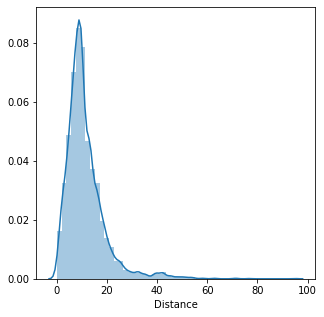

In [4]:
plt.figure(figsize=(5,5))
plt.tight_layout()
seabornInstance.distplot(datasets['Distance'])


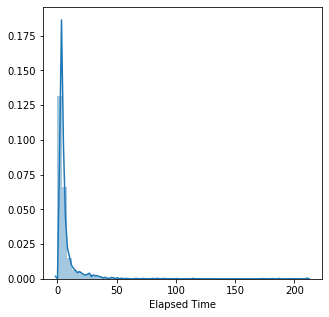

In [5]:
plt.figure(figsize=(5,5))
plt.tight_layout()
seabornInstance.distplot(datasets['Elapsed Time'])


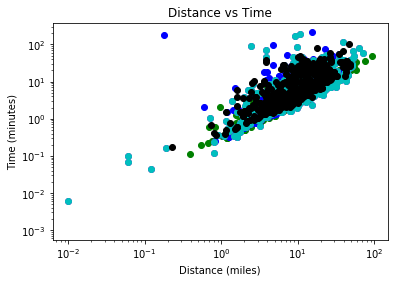

In [6]:
colors = ['r','g','b','m', 'c', 'k']
plt.figure()
for i in datasets['id'].unique():
    x = datasets[datasets.id == i]
    plt.plot(x['Distance'], x['Elapsed Time'], 'o', color = colors[i])
    
plt.title('Distance vs Time')  
plt.xlabel('Distance (miles)')  
plt.ylabel('Time (minutes)')  
plt.yscale('log')
plt.xscale('log')
plt.show()



A little bit of data cleaning. Get rid of NaN values


In [7]:
# get variables to use in regression
variables_to_use = ['Distance', 'Max Speed', 'Elevation Gain',
             'Max Grade', 'Average Grade','Elapsed Time', 'Relative Effort', 'id']
dataset_final = datasets[variables_to_use]
#dataset_final.mean()

In [8]:
predictors = ['Distance', 'Max Speed', 'Elevation Gain',
             'Max Grade', 'Average Grade', 'Relative Effort', 'id'];

# extra predictors that van be used later are: "Calories", 'Average Temperature',  'Elevation Loss', 'Relative Effort', 'Relative Effort'

X = datasets[predictors]
y = datasets['Elapsed Time']
X = X.fillna(method = 'pad')
X = X.fillna(0)
X.isnull().any()

Distance           False
Max Speed          False
Elevation Gain     False
Max Grade          False
Average Grade      False
Relative Effort    False
id                 False
dtype: bool

Can we predict run times with linear regression?

[0.9525417784978678, 0.5079746191695351, 0.30008212097968323, 0.3001462259447655, 0.5920692832920873]


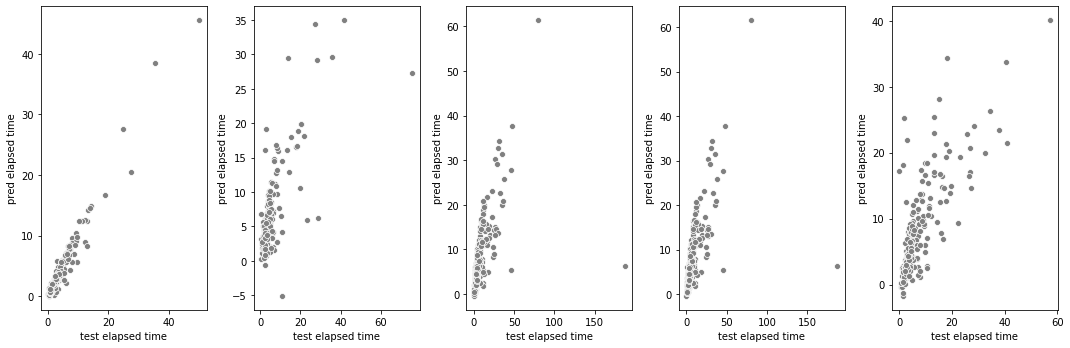

In [9]:
regressor = LinearRegression() 
scores = []
fig = plt.figure(figsize=(15,5))

for i in X['id'].unique():
    X_id = X[X.id == i]
    y_id = y[X.id == i]
    X_train, X_test, y_train, y_test = train_test_split(X_id, y_id, test_size=0.3, random_state=0)
    LR = regressor.fit(X_train, y_train) #training the algorithm
    scores.append(LR.score(X_test, y_test))
    
    fig.add_subplot(1, 5, i)    
    plt.tight_layout()
    X_test_id = X_test[X_test.id == i]
    y_pred = LR.predict(X_test_id)
    seabornInstance.scatterplot(y_test, y_pred, color = 'gray')
    plt.xlabel('test elapsed time')
    plt.ylabel('pred elapsed time')
    
    
print(scores)
plt.show()

There is obvious variablity in prediction of Elapsed Time

look at differences between subjects

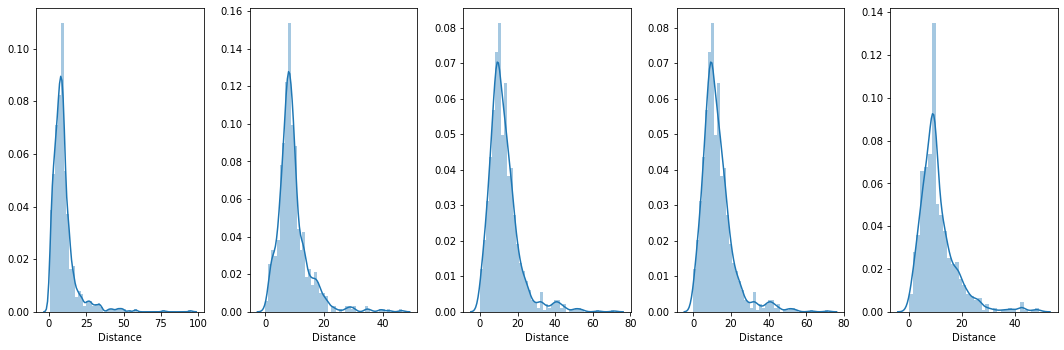

In [10]:
fig1 = plt.figure(figsize=(15,5))

for i in X['id'].unique():
    fig1.add_subplot(1, 5, i)    
    dataset = datasets[datasets.id == i]
    plt.tight_layout()
    seabornInstance.distplot(dataset['Distance'])

plt.show()

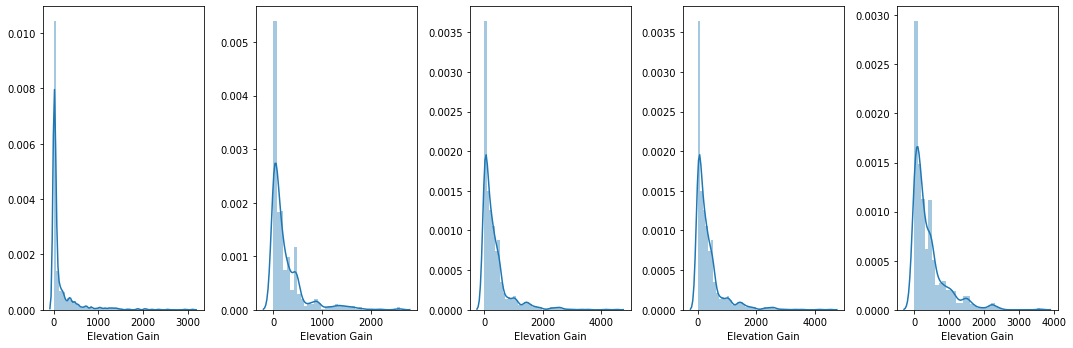

In [11]:
fig2 = plt.figure(figsize=(15,5))

for i in X['id'].unique():
    fig2.add_subplot(1, 5, i)    
    dataset = datasets[datasets.id == i]
    plt.tight_layout()
    seabornInstance.distplot(dataset['Elevation Gain'])

plt.show()

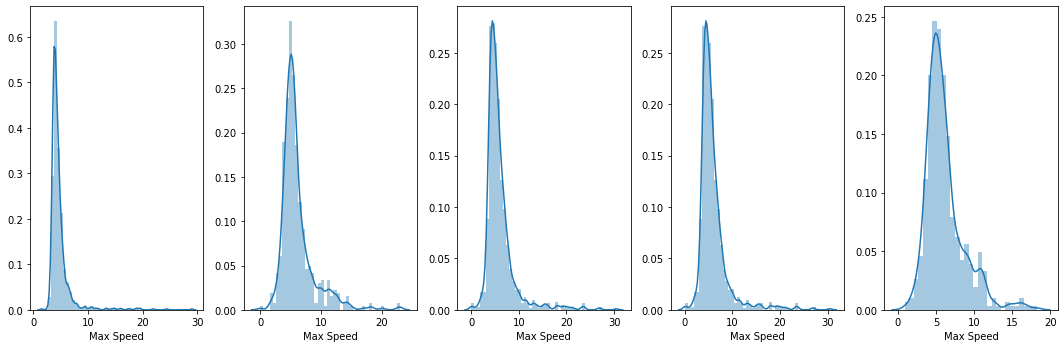

In [12]:
fig3 = plt.figure(figsize=(15,5))

for i in X['id'].unique():
    fig3.add_subplot(1, 5, i)    
    dataset = datasets[datasets.id == i]
    plt.tight_layout()
    seabornInstance.distplot(dataset['Max Speed'])

plt.show()

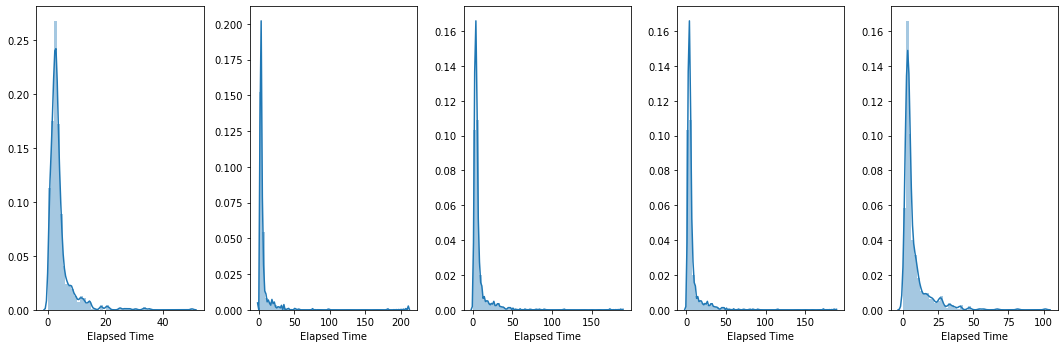

In [16]:
fig4 = plt.figure(figsize=(15,5))

for i in X['id'].unique():
    fig4.add_subplot(1, 5, i)    
    dataset = datasets[datasets.id == i]
    plt.tight_layout()
    seabornInstance.distplot(dataset['Elapsed Time'])
    
plt.show()

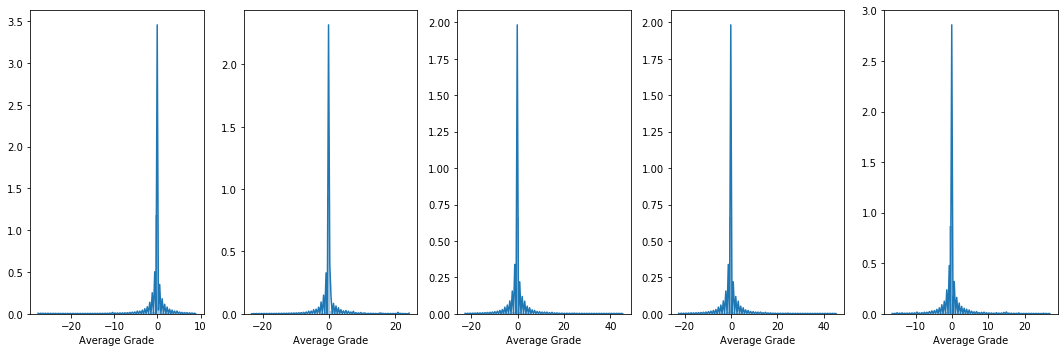

In [14]:
fig4 = plt.figure(figsize=(15,5))

for i in X['id'].unique():
    fig4.add_subplot(1, 5, i)    
    dataset = datasets[datasets.id == i]
    plt.tight_layout()
    seabornInstance.distplot(dataset['Average Grade'])
    

plt.show()

**Issues:**

1. Available features from each individual can vary. Can we estimate important information from each runner?

2. How to distinquish road runs from trails runs? Utilizing maps

